In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import cvxpy as cp
from sentence_transformers import SentenceTransformer, util
from scipy.optimize import linprog
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpInteger, LpBinary
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import pandas as pd

In [5]:
# Data

instagram_influencers = pd.read_csv("input/instagram_influencers.csv")
brands = pd.read_csv("input/brands.csv")
labeled_caption = pd.read_csv("input/labeled_caption.csv")
labeled_comment = pd.read_csv("input/labeled_comment.csv")
bio = pd.read_csv("input/bio.csv")
captions = pd.read_csv("input/captions.csv")

In [ ]:
class BudgetOptimizer:
    def __init__(self):
        pass

    def filter_and_optimize(self, brand_budget, influencers_df):
        """Filter influencers by budget + find optimal content mix"""
        filtered_influencers = []

        for _, infl in influencers_df.iterrows():
            if (brand_budget >= infl['rate_card_story'] or
                brand_budget >= infl['rate_card_feeds'] or
                brand_budget >= infl['rate_card_reels']):

                optimal_mix = self.optimize_content_mix(
                    budget=brand_budget,
                    story_rate=infl['rate_card_story'],
                    feeds_rate=infl['rate_card_feeds'],
                    reels_rate=infl['rate_card_reels'],
                    story_impact=self.estimate_story_impact(infl),
                    feeds_impact=self.estimate_feeds_impact(infl),
                    reels_impact=self.estimate_reels_impact(infl)
                )

                infl_dict = infl.to_dict()
                infl_dict.update({
                    'optimal_content_mix': optimal_mix,
                    'budget_efficiency': optimal_mix['total_impact'] / optimal_mix['total_cost'] if optimal_mix['total_cost'] > 0 else 0
                })
                filtered_influencers.append(infl_dict)

        return pd.DataFrame(filtered_influencers)

    def optimize_content_mix(self, budget, story_rate, feeds_rate, reels_rate, story_impact, feeds_impact, reels_impact):
        prob = LpProblem("OptimalContentMix", LpMaximize)

        x = LpVariable("story_count", 0, 5, cat=LpInteger)
        y = LpVariable("feeds_count", 0, 4, cat=LpInteger)
        z = LpVariable("reels_count", 0, 3, cat=LpInteger)

        use_story = LpVariable("use_story", 0, 1, LpBinary)
        use_feeds = LpVariable("use_feeds", 0, 1, LpBinary)
        use_reels = LpVariable("use_reels", 0, 1, LpBinary)

        prob += story_rate * x + feeds_rate * y + reels_rate * z <= budget

        prob += x >= 1 * use_story
        prob += x <= 1000 * use_story

        prob += y >= 1 * use_feeds
        prob += y <= 1000 * use_feeds

        prob += z >= 1 * use_reels
        prob += z <= 1000 * use_reels

        diversity_bonus = 5 * (use_story + use_feeds + use_reels)
        prob += story_impact * x + feeds_impact * y + reels_impact * z + diversity_bonus

        prob.solve()

        story_count = int(x.varValue)
        feeds_count = int(y.varValue)
        reels_count = int(z.varValue)
        total_cost = story_count * story_rate + feeds_count * feeds_rate + reels_count * reels_rate
        total_impact = story_count * story_impact + feeds_count * feeds_impact + reels_count * reels_impact
        remaining_budget = budget - total_cost

        return {
            'story_count': story_count,
            'feeds_count': feeds_count,
            'reels_count': reels_count,
            'total_cost': total_cost,
            'total_impact': total_impact,
            'remaining_budget': remaining_budget
        }

    def estimate_story_impact(self, influencer):
        """Estimate impact score for Instagram Story"""
        base_impact = influencer.get('engagement_rate_pct', 0.02) * 100
        tier_multiplier = {
            'Nano': 1.2, 'Micro': 1.1, 'Mid': 1.0, 'Macro': 0.9, 'Mega': 0.8
        }.get(influencer.get('tier_followers', 'Micro'), 1.0)
        return base_impact * tier_multiplier * 0.7

    def estimate_feeds_impact(self, influencer):
        """Estimate impact score for Instagram Feeds"""
        base_impact = influencer.get('engagement_rate_pct', 0.02) * 100
        tier_multiplier = {
            'Nano': 1.2, 'Micro': 1.1, 'Mid': 1.0, 'Macro': 0.9, 'Mega': 0.8
        }.get(influencer.get('tier_followers', 'Micro'), 1.0)
        return base_impact * tier_multiplier * 1.0

    def estimate_reels_impact(self, influencer):
        """Estimate impact score for Instagram Reels"""
        base_impact = influencer.get('engagement_rate_pct', 0.02) * 100
        viral_bonus = 1.5 if influencer.get('trending_status', False) else 1.2
        tier_multiplier = {
            'Nano': 1.3, 'Micro': 1.2, 'Mid': 1.1, 'Macro': 1.0, 'Mega': 0.9
        }.get(influencer.get('tier_followers', 'Micro'), 1.0)
        return base_impact * tier_multiplier * viral_bonus

class PersonaSemanticMatcher:
    def __init__(self, model_name='paraphrase-multilingual-MiniLM-L12-v2'):
        self.model = SentenceTransformer(model_name)
        self.caption_df = pd.read_csv("https://raw.githubusercontent.com/Fahmi-mi/Dataset/refs/heads/main/datathon-ristek-ui-2025/instagram/captions.csv")
        self.bio_df = pd.read_csv("https://raw.githubusercontent.com/Fahmi-mi/Dataset/refs/heads/main/datathon-ristek-ui-2025/instagram/bio.csv")

    def prepare_influencer_texts(self, bio_df=None, caption_df=None, max_posts=5):
        if bio_df is None:
            bio_df = self.bio_df
        if caption_df is None:
            caption_df = self.caption_df

        influencer_texts = {}
        grouped_captions = caption_df.groupby('instagram_account')

        for _, row in bio_df.iterrows():
            account = row['instagram_account']
            bio = str(row['bio']) if pd.notna(row['bio']) else ""

            captions = []
            if account in grouped_captions.groups:
                captions_raw = grouped_captions.get_group(account)['post_caption'].head(max_posts)
                captions = [str(c) for c in captions_raw if pd.notna(c)]

            full_text = bio + ' ' + ' '.join(captions)
            influencer_texts[account] = full_text.strip()

        return influencer_texts

    def calculate_similarity_scores(self, brand_persona_text, influencer_texts):
        """
        Hitung cosine similarity antara brand persona dan teks masing-masing influencer.
        :param brand_persona_text: str
        :param influencer_texts: dict {instagram_account: full_text}
        :return: dict {instagram_account: similarity_score}
        """
        scores = {}
        brand_vec = self.model.encode(brand_persona_text)

        accounts = list(influencer_texts.keys())
        texts = list(influencer_texts.values())

        infl_vecs = self.model.encode(texts, show_progress_bar=False)
        brand_vec = self.model.encode(brand_persona_text)

        cosine_scores = cosine_similarity([brand_vec], infl_vecs)[0]
        scores = dict(zip(accounts, cosine_scores))

        return scores

    def get_scored_df(self, brand_persona_text, bio_df, caption_df):
        """
        Mengembalikan DataFrame berisi akun influencer dan skor kecocokan persona.
        :return: DataFrame dengan kolom ['instagram_account', 'persona_fit_score']
        """
        influencer_texts = self.prepare_influencer_texts(bio_df, caption_df)
        scores = self.calculate_similarity_scores(brand_persona_text, influencer_texts)
        return pd.DataFrame([
            {'instagram_account': account, 'persona_fit_score': score}
            for account, score in scores.items()
        ])

class DemoPsychoMatcher:
    def __init__(self):
        self.demo_weights = {
            'demography_usia': 0.3,
            'demography_gender': 0.25,
            'demography_income': 0.2,
            'psychography_lifestyle': 0.15,
            'psychography_personality': 0.1
        }

    def calculate_demographic_similarity(self, brand_demo, influencer_demo):
        """Calculate weighted demographic similarity score"""
        total_score = 0
        total_weight = 0

        for field, weight in self.demo_weights.items():
            brand_values = self.parse_list_field(brand_demo.get(field, []))
            infl_values = self.parse_list_field(influencer_demo.get(field, []))

            if brand_values and infl_values:
                intersection = len(set(brand_values) & set(infl_values))
                union = len(set(brand_values) | set(infl_values))
                jaccard_sim = intersection / union if union > 0 else 0
                total_score += weight * jaccard_sim
                total_weight += weight

        return total_score / total_weight if total_weight > 0 else 0

    def parse_list_field(self, field_value):
        """Parse string representation of list"""
        if isinstance(field_value, str):
            try:
                if field_value.startswith('[') and field_value.endswith(']'):
                    return eval(field_value)
                else:
                    return [field_value]
            except:
                return [field_value]
        elif isinstance(field_value, list):
            return field_value
        else:
            return [str(field_value)] if field_value is not None else []


class SocialMediaPerformancePredictor:
    def __init__(self):
        self.tier_benchmarks = {
            'Nano': {'engagement': 0.04, 'views': 5000},
            'Micro': {'engagement': 0.02, 'views': 25000},
            'Mid': {'engagement': 0.015, 'views': 75000},
            'Macro': {'engagement': 0.012, 'views': 200000},
            'Mega': {'engagement': 0.01, 'views': 500000}
        }
        self.model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')


    def predict_campaign_performance(self, influencer_data, brand_data):
        """Predict campaign performance using heuristic approach"""
        # Calculate performance components
        engagement_score = self.calculate_engagement_score(influencer_data)
        authenticity_score = self.calculate_authenticity_score(influencer_data)
        reach_potential = self.calculate_reach_potential(influencer_data)
        brand_fit = self.calculate_brand_fit(influencer_data, brand_data)

        # Combined performance score
        performance_score = (
            engagement_score * 0.3 +
            authenticity_score * 0.25 +
            reach_potential * 0.25 +
            brand_fit * 0.2
        )

        return {
            'performance_score': min(performance_score, 1.0),
            'engagement_score': engagement_score,
            'authenticity_score': authenticity_score,
            'reach_potential': reach_potential,
            'brand_fit': brand_fit
        }

    def calculate_engagement_score(self, influencer_data):
        """Calculate engagement quality score"""
        er = influencer_data.get('engagement_rate_pct', 0)
        tier = influencer_data.get('tier_followers', 'Micro')
        benchmark = self.tier_benchmarks.get(tier, {'engagement': 0.02})['engagement']

        normalized_er = min(er / benchmark, 2.0) if benchmark > 0 else 0
        return normalized_er / 2.0

    def calculate_authenticity_score(self, influencer_data):
        """Calculate authenticity based on endorse rate and consistency"""
        endorse_rate = influencer_data.get('random_endorse_rate', 0.5)
        consistency = influencer_data.get('behavior_consistency', False)

        authenticity = (1 - endorse_rate) * 0.7
        if consistency:
            authenticity += 0.3

        return min(authenticity, 1.0)

    def calculate_reach_potential(self, influencer_data):
        """Calculate reach potential based on views and virality"""
        avg_views = influencer_data.get('avg_reels_views', 0)
        trending = influencer_data.get('trending_status', False)
        tier = influencer_data.get('tier_followers', 'Micro')

        benchmark = self.tier_benchmarks.get(tier, {'views': 25000})['views']
        view_score = min(avg_views / benchmark, 2.0) / 2.0 if benchmark > 0 else 0

        if trending:
            view_score *= 1.2

        return min(view_score, 1.0)

    def calculate_brand_fit(self, influencer_data, brand_data):
        """Calculate brand fit using sentence embeddings and cosine similarity"""
        infl_text = influencer_data.get('expertise_field', '')
        brand_text = brand_data.get('industry_description', brand_data.get('industry', ''))

        if not infl_text or not brand_text:
            return 0.0  # Fallback jika data kosong

        emb_influencer = self.model.encode(infl_text, convert_to_tensor=True)
        emb_brand = self.model.encode(brand_text, convert_to_tensor=True)

        score = util.cos_sim(emb_influencer, emb_brand).item()
        return min(max(score, 0.0), 1.0)

class MultiObjectiveRanker:
    def __init__(self):
        self.main_objectives = ['demo_fit', 'performance_pred', 'budget_efficiency']
        self.placeholder_objectives = ['persona_fit']

    def rank_influencers(self, scored_influencers, brand_priorities):
        if not scored_influencers:
            return []

        for obj in self.main_objectives:
            scores = [infl[obj] for infl in scored_influencers]
            if scores: 
                min_score, max_score = min(scores), max(scores)
                for infl in scored_influencers:
                    if max_score > min_score:
                        infl[f'{obj}_normalized'] = (infl[obj] - min_score) / (max_score - min_score)
                    else:
                        infl[f'{obj}_normalized'] = 0.5

        for obj in self.placeholder_objectives:
            for infl in scored_influencers:
                infl[f'{obj}_normalized'] = infl[obj]

        all_objectives = self.main_objectives + self.placeholder_objectives
        for infl in scored_influencers:
            final_score = sum(
                infl[f'{obj}_normalized'] * brand_priorities.get(obj, 0.25)
                for obj in all_objectives
            )
            infl['final_score'] = final_score

        return sorted(scored_influencers, key=lambda x: x['final_score'], reverse=True)


class SOTAInfluencerMatcher:
    def __init__(self):
        self.budget_optimizer = BudgetOptimizer()
        self.persona_matcher = PersonaSemanticMatcher()
        self.demo_psycho_matcher = DemoPsychoMatcher()
        self.performance_predictor = SocialMediaPerformancePredictor()
        self.final_ranker = MultiObjectiveRanker()


In [ ]:
def get_top_influencers_for_brand(brand_name, brands_df, influencers_df, bio_df, caption_df, top_n=3):
    matcher = SOTAInfluencerMatcher()

    brand_data = brands_df[brands_df['brand_name'] == brand_name]
    if brand_data.empty:
        print(f"❌ Brand '{brand_name}' not found!")
        return []

    brand = brand_data.iloc[0]
    print(f"🎯 Finding top {top_n} influencers for: {brand['brand_name']}")
    print(f"💰 Budget: Rp {brand['budget']:,}")
    print(f"🎪 Industry: {brand['industry']}")
    print(f"📝 Criteria: {brand['brand_criteria']}")
    print("-" * 60)

    print("🔍 Stage 1: Budget Filtering...")
    affordable_influencers = matcher.budget_optimizer.filter_and_optimize(
        brand['budget'], influencers_df
    )

    if affordable_influencers.empty:
        print(f"❌ No influencers found within budget of Rp {brand['budget']:,}")
        return []

    print(f"✅ Found {len(affordable_influencers)} affordable influencers")

    print("🧠 Stage 2: Persona Matching (Semantic)...")
    persona_scores_df = matcher.persona_matcher.get_scored_df(
        brand_persona_text=brand['brand_criteria'],
        bio_df=bio_df[['instagram_account', 'bio']],
        caption_df=caption_df
    )

    affordable_influencers = pd.merge(
    affordable_influencers,
    persona_scores_df.rename(columns={'persona_fit_score': 'persona_fit'}),
    left_on='username_instagram',
    right_on='instagram_account',
    how='left'
    )

    affordable_influencers['persona_fit'] = affordable_influencers['persona_fit'].fillna(0.5)

    print("📊 Stage 3-4: Scoring influencers...")
    scored_influencers = []

    for _, infl in affordable_influencers.iterrows():
        persona_score = infl.get('persona_fit', 0.5)

        demo_score = matcher.demo_psycho_matcher.calculate_demographic_similarity(
            brand.to_dict(), infl.to_dict()
        )

        performance = matcher.performance_predictor.predict_campaign_performance(
            infl.to_dict(), brand.to_dict()
        )

        scored_influencers.append({
            'brand': brand['brand_name'],
            'influencer': infl['username_instagram'],
            'influencer_id': infl['influencer_id'],
            'tier': infl['tier_followers'],
            'persona_fit': persona_score,
            'demo_fit': demo_score,
            'performance_pred': performance['performance_score'],
            'budget_efficiency': infl['budget_efficiency'],
            'optimal_content_mix': infl['optimal_content_mix'],
            'engagement_rate': infl['engagement_rate_pct'],
            'authenticity_score': performance['authenticity_score'],
            'reach_potential': performance['reach_potential'],
            'brand_fit': performance['brand_fit'],
            # Raw influencer data for detailed insights
            'raw_influencer_data': infl.to_dict()
        })

    print("🏆 Stage 5: Final Ranking...")
    brand_priorities = {
        'persona_fit': 0.1,      
        'demo_fit': 0.45,        
        'performance_pred': 0.35,
        'budget_efficiency': 0.1 
    }

    final_rankings = matcher.final_ranker.rank_influencers(scored_influencers, brand_priorities)

    top_recommendations = final_rankings[:top_n]
    print(f"✅ Generated top {len(top_recommendations)} recommendations")

    return top_recommendations

In [ ]:
def display_brand_recommendation_simple(brand_name, brands_df, influencers_df, caption_df, comment_df,bio_df, top_n=3):
    recommendations = get_top_influencers_for_brand(brand_name, brands_df, influencers_df, bio_df, caption_df, top_n)

    if not recommendations:
        print("No recommendations found.")
        return

    print(f"\n{'='*80}")
    print(f"📊 BRAND SUMMARY: {brand_name.upper()}")
    print(f"{'='*80}")
    print(generate_brand_summary(brands_df, brand_name))
    print(f"\n{'='*80}")
    print(f"🎯 TOP {top_n} INFLUENCER RECOMMENDATIONS FOR: {brand_name.upper()}")
    print(f"{'='*80}")

    for i, rec in enumerate(recommendations, 1):
      tier_emoji = {"Nano": "🔥", "Micro": "⭐", "Mid": "🚀", "Macro": "💎", "Mega": "👑"}.get(rec['tier'], "📱")

      print(f"\n{i}. {tier_emoji} @{rec['influencer']} ({rec['tier']} Influencer)")
      print(f"   📊 Overall Match Score: {rec['final_score']:.1%}")

      insight = generate_influencer_insight(
          username=rec['influencer'],
          caption_df=caption_df,
          comment_df=comment_df,
          show_plot=True
      )
      for line in insight.split("\n"):
          print(f"   {line}")

      print(f"\n   🎯 Score Breakdown:")
      print(f"      • Budget Efficiency:      {rec['budget_efficiency'] * 1_000_000:.2f} points/Million Rp")
      print(f"      • Persona Fit:           {rec['persona_fit']:.1%}")
      print(f"      • Demographic Fit:       {rec['demo_fit']:.1%}")
      print(f"      • Performance Potential:  {rec['performance_pred']:.1%}")

      print(f"\n   📈 Performance Metrics:")
      print(f"      • Engagement Rate:       {rec['engagement_rate']:.2%}")
      print(f"      • Authenticity Score:    {rec['authenticity_score']:.1%}")
      print(f"      • Reach Potential:       {rec['reach_potential']:.1%}")
      print(f"      • Brand Alignment:       {rec['brand_fit']:.1%}")

      print(f"\n   💰 Optimal Campaign Strategy:")
      mix = rec['optimal_content_mix']
      if mix['story_count'] > 0:
          print(f"      • Instagram Stories: {mix['story_count']} posts")
      if mix['feeds_count'] > 0:
          print(f"      • Feed Posts: {mix['feeds_count']} posts")
      if mix['reels_count'] > 0:
          print(f"      • Reels: {mix['reels_count']} posts")

      print(f"\n   💳 Financial Summary:")
      print(f"      • Total Investment:      Rp {mix['total_cost']:,}")
      print(f"      • Budget Remaining:      Rp {mix['remaining_budget']:,}")
      print(f"      • Expected Impact:       {mix['total_impact']:.1f} points")

      raw_data = rec['raw_influencer_data']
      insights = []
      if raw_data.get('trending_status', False):
          insights.append("🔥 Currently trending")
      if raw_data.get('behavior_consistency', False):
          insights.append("✅ Consistent content behavior")
      if raw_data.get('campaign_success_signif', False):
          insights.append("🎯 Proven campaign success")
      if raw_data.get('random_endorse_rate', 1) < 0.3:
          insights.append("🏅 Low endorsement frequency (authentic)")
      elif raw_data.get('random_endorse_rate', 1) > 0.7:
          insights.append("⚠️ High endorsement frequency")

      if insights:
          print(f"\n   💡 Key Insights:")
          for insight in insights:
              print(f"      • {insight}")

      if i < len(recommendations):
          print(f"\n{'-' * 80}")


In [12]:
import ast

def generate_brand_summary(df, brand_name):
    row = df[df['brand_name'].str.lower() == brand_name.lower()].iloc[0]

    def format_list(val):
        try:
            val_list = ast.literal_eval(val) if isinstance(val, str) else val
            if isinstance(val_list, list):
                return ', '.join(val_list[:-1]) + f' & {val_list[-1]}' if len(val_list) > 1 else val_list[0]
            return str(val_list)
        except:
            return str(val)

    gender = format_list(row['demography_gender'])
    age_group = format_list(row['demography_usia'])
    income = format_list(row['demography_income'])
    lifestyle = format_list(row['psychography_lifestyle'])
    personality = format_list(row['psychography_personality'])
    values = format_list(row['psychography_value'])
    growth_type = str(row['growth_type']).title()
    marketing_goal = str(row['marketing_goal']).title()
    budget = f"± Rp {int(row['budget']):,}".replace(",", ".")

    summary = f"""
🧠 BRAND PROFILE: {row['brand_name'].title()}
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎯 Target Persona:
• Gender        : {gender}
• Age Group     : {age_group}
• Income Level  : {income}
• Lifestyle     : {lifestyle}
• Personality   : {personality}
• Core Values   : {values}

📈 Brand Objective:
• Growth Type       : {growth_type}
• Marketing Goal    : {marketing_goal}
• Budget Allocation : {budget}
• Brand Criteria    : {row['brand_criteria']}
"""
    return summary.strip()

In [ ]:
def generate_influencer_insight(username: str, caption_df: pd.DataFrame, comment_df: pd.DataFrame, show_plot: bool = False) -> str:
    result = f"🔁 Conversion Potential for @{username}\n"

    captions = caption_df[caption_df["instagram_account"] == username]
    comments = comment_df[comment_df["instagram_account"] == username]

    comment_counts = None
    if not comments.empty:
        comment_counts = comments["predicted_label"].value_counts(normalize=True).mul(100).round(1)
        total_comments = len(comments)
        result += f"\n💬 Comment Quality\nTotal {total_comments} komentar dianalisis.\n"

        for label, pct in comment_counts.items():
            label_id = label.lower().replace("_", " ")
            result += f"{pct:.1f}% {label_id}\n"

        high_value_labels = ["relatable engagement", "product-focused response", "social virality"]
        high_value_pct = sum([comment_counts.get(lbl, 0) for lbl in comment_counts.index if lbl.lower() in high_value_labels])
        result += f"🎯 High-Value Comment Rate: {high_value_pct:.1f}%\n"
        if high_value_pct < 20:
            result += "Cukup rendah, mengindikasikan bahwa interaksi dari audiens masih dominan pujian atau pasif.\n"

        result += "\n💬 Komentar Berkualitas Tinggi yang Mewakili Audiens\n"
        for label in high_value_labels:
            label_comments = comments[comments["predicted_label"].str.lower() == label]
            if not label_comments.empty:
                result += f"\n🔹 {label.title()}\n"
                example = label_comments["comment"].iloc[0]
                result += f"Contoh:\n“{example}”\n"
            else:
                if label == "product-focused response":
                    result += "\n🔹 Product-Focused Response (minat terhadap produk)\nTidak ditemukan komentar yang membahas produk secara langsung pada postingan terakhir.\n"

        if total_comments < 20:
            result += f"\n⚠️ Hanya {total_comments} komentar terdeteksi. Insight ini mungkin kurang representatif karena volume interaksi yang rendah.\n"
    else:
        result += "\nTidak ada komentar yang dapat dianalisis.\n"

    result += f"\n📢 Caption Behavior Summary – Influencer: {username}\n"
    caption_counts = None
    if not captions.empty:
        cta_labels = ["call-to-action", "engagement-inviting"]
        cta_count = captions["predicted_label"].str.lower().isin(cta_labels).sum()
        total_captions = len(captions)
        result += f"\n🔁 Call-to-Action Habit:\n{cta_count} dari {total_captions} caption mengandung CTA.\n"
        if cta_count > 0:
            example_cta = captions[captions["predicted_label"].str.lower().isin(cta_labels)]["post_caption"].iloc[0]
            result += f"Contoh:\n“{example_cta[:120]}...”\n"

        prod_labels = ["product-focused", "brand awareness"]
        prod_count = captions["predicted_label"].str.lower().isin(prod_labels).sum()
        if prod_count > 0:
            example_prod = captions[captions["predicted_label"].str.lower().isin(prod_labels)]["post_caption"].iloc[0]
            result += f"\n🛍️ Product Mention:\n{prod_count} caption menyebut produk atau brand.\nContoh:\n“{example_prod[:120]}...”\n"

        caption_counts = captions["predicted_label"].value_counts()
        dominant_label = caption_counts.idxmax()
        result += f"\n🎭 Tone of Voice:\nDominan: {dominant_label}.\n"
        example_tone = captions[captions["predicted_label"] == dominant_label]["post_caption"].iloc[0]
        result += f"Contoh:\n“{example_tone[:120]}...”\n"

        if cta_count > 0:
            result += f"\n💬 Engagement Style:\n{cta_count} caption mengandung ajakan interaksi.\n"

        result += f"\n📊 Distribusi label utama:\n"
        for lbl, cnt in caption_counts.items():
            result += f"{lbl}: {cnt}\n"

        if "brand awareness" in caption_counts.index:
            result += "\n💡 Insight:\nGaya caption menunjukkan fokus pada membangun kesadaran merek, cocok untuk kampanye awareness.\n"
        if cta_count > 0:
            result += "Juga ditemukan upaya interaksi dua arah dengan audiens.\n"
    else:
        result += "\nTidak ada caption yang dapat dianalisis.\n"

    if show_plot and (caption_counts is not None or comment_counts is not None):
        import matplotlib.pyplot as plt
        import seaborn as sns

        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        if caption_counts is not None:
            sns.barplot(x=caption_counts.index, y=caption_counts.values, palette="pastel", ax=axes[0])
            axes[0].set_title("Caption Label Distribution")
            axes[0].set_ylabel("Count")
            axes[0].set_xlabel("Caption Label")
            axes[0].tick_params(axis='x', rotation=30)
        else:
            axes[0].axis('off')
            axes[0].set_title("No Caption Data")

        if comment_counts is not None:
            sns.barplot(x=comment_counts.index, y=comment_counts.values, palette="muted", ax=axes[1])
            axes[1].set_title("Comment Label Distribution (%)")
            axes[1].set_ylabel("Percentage (%)")
            axes[1].set_xlabel("Comment Label")
            axes[1].tick_params(axis='x', rotation=30)
        else:
            axes[1].axis('off')
            axes[1].set_title("No Comment Data")

        plt.suptitle(f"@{username} Content & Audience Label Distribution", fontsize=13, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    return result

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🎯 Finding top 3 influencers for: Good Day
💰 Budget: Rp 28,000,000
🎪 Industry: FMCG
📝 Criteria: self-care aktif di Instagram Gen Z gaya ceria self-care
------------------------------------------------------------
🔍 Stage 1: Budget Filtering...
✅ Found 153 affordable influencers
🧠 Stage 2: Persona Matching (Semantic)...
📊 Stage 3-4: Scoring influencers...
🏆 Stage 5: Final Ranking...
✅ Generated top 3 recommendations

📊 BRAND SUMMARY: GOOD DAY
🧠 BRAND PROFILE: Good Day
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎯 Target Persona:
• Gender        : Laki-laki
• Age Group     : Generasi Z & Milenial
• Income Level  : Menengah & Atas
• Lifestyle     : Aktif & Sehat
• Personality   : Ceria & Ekspresif
• Core Values   : Estetika & Kesehatan

📈 Brand Objective:
• Growth Type       : High
• Marketing Goal    : Affective
• Budget Allocation : ± Rp 28.000.000
• Brand Criteria    : self-care aktif di Instagram Gen Z gaya ceria self-care

🎯 TOP 3 INFLUENCER RECOMMENDATIONS FOR: GOOD DAY

1. 👑 @attahalilintar (Meg

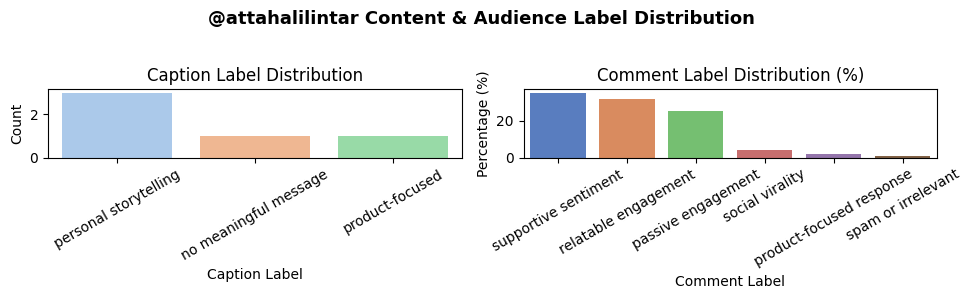

   🔁 Conversion Potential for @attahalilintar
   
   💬 Comment Quality
   Total 192 komentar dianalisis.
   35.4% supportive sentiment
   31.8% relatable engagement
   25.5% passive engagement
   4.2% social virality
   2.1% product-focused response
   1.0% spam or irrelevant
   🎯 High-Value Comment Rate: 38.1%
   
   💬 Komentar Berkualitas Tinggi yang Mewakili Audiens
   
   🔹 Relatable Engagement
   Contoh:
   “Pernah jadi A-TEAM pada masa nya 🗿, ternyata benar kata coki-muslim musuh besar A-TEAM adalah kedawasaan 🤣”
   
   🔹 Product-Focused Response
   Contoh:
   “Kontrak sama pemerintahnya udah abis belum?”
   
   🔹 Social Virality
   Contoh:
   “Bang @attahalilintar berkehidupan di era skrg berkat para pejuang kemerdekaan ...”
   
   📢 Caption Behavior Summary – Influencer: attahalilintar
   
   🔁 Call-to-Action Habit:
   0 dari 5 caption mengandung CTA.
   
   🛍️ Product Mention:
   1 caption menyebut produk atau brand.
   Contoh:
   “Saya yang kerja, dia yang belanja. Yang makan

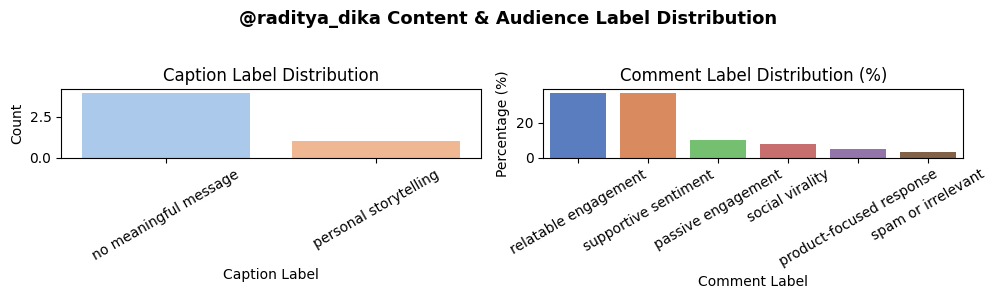

   🔁 Conversion Potential for @raditya_dika
   
   💬 Comment Quality
   Total 197 komentar dianalisis.
   37.1% relatable engagement
   37.1% supportive sentiment
   10.2% passive engagement
   7.6% social virality
   5.1% product-focused response
   3.0% spam or irrelevant
   🎯 High-Value Comment Rate: 49.8%
   
   💬 Komentar Berkualitas Tinggi yang Mewakili Audiens
   
   🔹 Relatable Engagement
   Contoh:
   “itu baru tiang listrik bang belum perbedaan sutet sutet diseluruh dunia..”
   
   🔹 Product-Focused Response
   Contoh:
   “Kak kalo nonton stand up kaka, aman ga ya obrolannya kalo bawa balita?”
   
   🔹 Social Virality
   Contoh:
   “nu iki koe? @ibnutrip”
   
   📢 Caption Behavior Summary – Influencer: raditya_dika
   
   🔁 Call-to-Action Habit:
   0 dari 5 caption mengandung CTA.
   
   🎭 Tone of Voice:
   Dominan: no meaningful message.
   Contoh:
   “Ada yang main juga?...”
   
   📊 Distribusi label utama:
   no meaningful message: 4
   personal storytelling: 1
   

   🎯 S

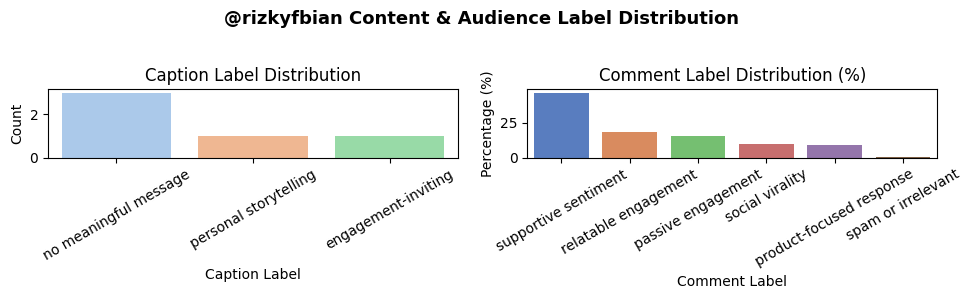

   🔁 Conversion Potential for @rizkyfbian
   
   💬 Comment Quality
   Total 207 komentar dianalisis.
   46.9% supportive sentiment
   18.4% relatable engagement
   15.5% passive engagement
   10.1% social virality
   8.7% product-focused response
   0.5% spam or irrelevant
   🎯 High-Value Comment Rate: 37.2%
   
   💬 Komentar Berkualitas Tinggi yang Mewakili Audiens
   
   🔹 Relatable Engagement
   Contoh:
   “lagu kamu gak pernah gagal ka😢”
   
   🔹 Product-Focused Response
   Contoh:
   “Kaget bgt muka aku pertamaaaaa😭😭😭😭😭🙌🏻🙌🏻🙌🏻”
   
   🔹 Social Virality
   Contoh:
   “Di intro banget @bintanggrendiss 😭”
   
   📢 Caption Behavior Summary – Influencer: rizkyfbian
   
   🔁 Call-to-Action Habit:
   1 dari 5 caption mengandung CTA.
   Contoh:
   “Bukan cuma indah , tapi km jadi tempat paling tenang...”
   
   🎭 Tone of Voice:
   Dominan: no meaningful message.
   Contoh:
   “BALI MENGPADEL 💙...”
   
   💬 Engagement Style:
   1 caption mengandung ajakan interaksi.
   
   📊 Distribusi labe

In [ ]:
display_brand_recommendation_simple(
    brand_name="Good Day",
    brands_df=brands,
    influencers_df=instagram_influencers,
    caption_df=labeled_caption,
    comment_df=labeled_comment,
    bio_df=bio
)